# Homework 2 | Optimization
4.453x Creative Machine Learning for Design<br/>
*Renaud Danhaive, Ous Abou Ras, Natasha Hirt, Caitlin Mueller*
<br/><br/>


---

👋 Welcome to the second assignment of 4.453x!! 👋 
<br/><br/>

💡 In this assignment, **you will learn how to**:

- Visualize a constrained problem.
- Optimize a constrained problem over 2 variables using `Pytorch`.
- Design the objective function to make it differentiable.
- Optimize a constrained problem over 3 variables using  `nlopt`.
- Create an interactive app to visualization the optimization path.
<br/><br/>

❗❗❗ The deliverable for this homework is a *viewable* link to your completed notebook AND a *viewable* link to your solution for the [quiz](https://colab.research.google.com/drive/1k3ckHifi-otfNlBQQSqPmWPSJMvYveYx?usp=sharing). *It is your responsibility to rerun your notebook and make sure everything is running before submitting.*

❗❗❗ For questions that require you to submit a textual or visual answer, please collect your results in a separate Google Docs file to be shared at the end of the notebook.
For questions that request numerical results, you may simply print them with your code.

🤖 <font size="-1">At the risk of sounding like a broken record, we encourage you to practice good coding hygiene. This will help you write better code faster.
Remember:
- Explicit is better than implicit when naming objects. For example, a variable pointing to an array of dog images is better named as `dog_images_array` than as `d_array`.
- Don't repeat yourself (DRY). If you find yourself copy-pasting code, it's a good sign you should put that code in a function.
- Try to produce code that could almost be read as a sentence by somebody with some knowledge of what the code is trying to accomplish.
- More readable code is (almost always) better code. </font>

---

# ~. Imports 📦

**RESTART** the runtime after running the cell below.
Whenever you update a library in Colab, you will need to restart the runtime. Here, we are updating the numpy package to work with the nlopt package.

*To restart the runtime, click on "Runtime" above, and then "Restart Runtime"*

In [2]:
try:
    import trimesh
    import nlopt
    from jupyter_dash import JupyterDash
    import dash_bootstrap_components
except ModuleNotFoundError:
    # !pip install -U numpy
    !pip install nlopt==2.7.0 &> /dev/null
    !pip install trimesh &> /dev/null    
    !pip install dash==2.8.1 &> /dev/null
    !pip install jupyter-dash &> /dev/null
    !pip install dash-bootstrap-components &> /dev/null

from google.colab import output

output.enable_custom_widget_manager()


# Scientific computing
import numpy as np
import torchvision
import torch
import scipy
import sklearn
from skimage.measure import find_contours 

# visualizations and interactivity
import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

# dash and plotly
import plotly.io as pio
from jupyter_dash import JupyterDash
import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import dash_bootstrap_components as dbc

# mesh library for 3d visualization
from trimesh.creation import cylinder
from trimesh.util import concatenate

# caching to avoid unnecessary recomputations
from functools import lru_cache

# optimization package
import nlopt

In [3]:
# @title Styling
# @markdown Making things pretty! (This is meant to work with Colab's dark theme **(Settings > Site > Theme > "Dark")**.)
import google
is_dark = google.colab.output.eval_js(
    'document.documentElement.matches("[theme=dark]")'
)

matplotlib.rcParams["figure.dpi"] = 100
plt.rcParams["hatch.color"] = "white"

if is_dark:
    # load style sheet for matplotlib, a plotting library we use for 2D visualizations
    plt.style.use(
        "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle"
    )
    plt.style.use("dark_background")
    plt.rcParams.update(
        {
            "figure.facecolor": (0.22, 0.22, 0.22, 1.0),
            "axes.facecolor": (0.22, 0.22, 0.22, 1.0),
            "savefig.facecolor": (0.22, 0.22, 0.22, 1.0),
            "grid.color": (0.4, 0.4, 0.4, 1.0),
        }
    )

    plotly_template = pio.templates["plotly_dark"]
    pio.templates["draft"] = go.layout.Template(
        layout=dict(
            plot_bgcolor="rgba(56,56,56,0)",
            paper_bgcolor="rgba(56,56,56,0)",
        )
    )
    pio.templates.default = "plotly_dark+draft"
else:
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle"

# A. Constrained optimization with 2 variables via conversion to unconstrained optimization with penalty function 🐍
In class, we showed how we can optimize a function using `PyTorch`'s autodiff engine and built-in optimizers. One limitation of `PyTorch` is that it does not offer a constrained optimizer out-of-the-box. You can bet there are packages that extend `PyTorch` to do just that, but we can also modify/penalize our objective function in non-feasible regions such that an unconstrained optimizer will naturally avoid these unfeasible regions.

💥 There are other, more rigorous ways to turn constrained optimization problems into unconstrained ones. For example, under certain conditions, the method of *Lagrange multipliers* allows to reformulate a constrained problem into an equivalent unconstrained one. That's not what we'll be doing here, but we encourage you to read up about that method.

Here is the problem we will try to solve:
\begin{equation}
min_{x_1,x_2}\frac{1}{2}\sum_{i=1}^{i=2}{(x_i^4 - 16*x_i^2+5*x_i)}
\\
\text{subject to: }\\
x_1^2+x_2^2-r^2<=0
\end{equation}

You might recognize the objective function. It's the same one we optimized in [the notebook we coded in class](https://colab.research.google.com/drive/1vAfrR4CiACw0n899xC8uJ3UMwKyonCQa?usp=sharing).

## Question 1.0 | Visualize the problem 👀
----
The problem is 2D so we can visualize it easily. Most optimization problems are not visualized as easily, but that's the beauty of toy problems: you can plot everything to validate your approach.

Produce a contour plot of the objective function over $[-5,5]×[-5,5]$ with the unfeasible region hatched-out. Use a slider widget to make the corresponding plot interactive to a change in the value of $r$.

The Autodiff notebook we live-coded in week 2 contains an [example of widget use](https://colab.research.google.com/drive/1vAfrR4CiACw0n899xC8uJ3UMwKyonCQa?usp=sharing).  
The week 2 notebook on N-pods contains an [example of constraint plotting](https://colab.research.google.com/drive/1BcWnY0Bfoh7zOr5bGJTE9fd3wb9omSQY?usp=sharing&authuser=1#scrollTo=QdXwWljVVKLh).
<br/><br/>

<font size="-1">*Hint 1: We are expecting a constraint boundary that has a circular shape. The constraint, which might be familiar, is actually the equation of a circle!*

*Hint 2: Check the shapes of your variables. Does it make sense? The  shape of your grid should be (2, resolution, resolution). 2 for x and y.*</font>

### 1.1 ❓ Let's start by defining the Styblinski Tang formula above, and sampling the function with a regular grid.

In [ ]:
# 1. Define the styblinski_tang formula as a function
def styblinski_tang(x,dim=0):
  sum_terms = x**4 - 16*x**2+5*x
  return torch.sum(sum_terms,dim=0)/2

# 2. Define the bounds for x1 and x2, and resolution
resolution = 40
bounds = [-5, 5]

# 3. Define the grid using bounds and resolution. call it `grid`
with torch.no_grad():
  coordinates = torch.linspace(bounds[0], bounds[1], resolution)
  grid_x, grid_y = torch.meshgrid(coordinates, coordinates, indexing = "ij")

grid = torch.cat([grid_x.unsqueeze(0), grid_y.unsqueeze(0)])
print(grid.shape)
# 4. Sample the space using the grid
values = styblinski_tang(grid)
values.shape


torch.Size([2, 40, 40])


torch.Size([40, 40])

### 1.2 ❓ Show a contour plot of the sampled values (**without** constraints). You can use `plt.contourf`. 

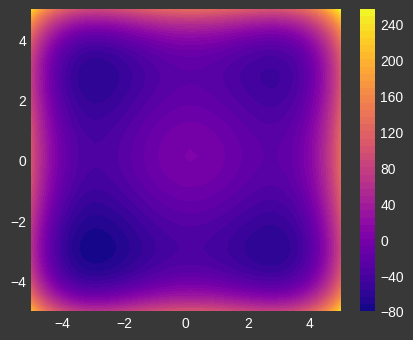

In [ ]:
plt.figure(figsize=(5,4))
plt.contourf(grid_x.numpy(), grid_y.numpy(), values.numpy(), levels=50, cmap="plasma")
plt.colorbar()

### 1.3 ❓ Write a function to check constraints given a sample from the grid.

In [ ]:
def constraint_func(sample_grid, r):
    """
    Returns True if we are within the constraint, otherwise False
    """
    x = sample_grid[0]
    y = sample_grid[1]
    return (x**2 + y**2) <= r**2
    ##### TO DO  #####

### 1.4 ❓ Next, we will make a function to show the plot *with* the constraints. We are adding a few things the plot prettier, but feel free to mess with it and create your own style!

In [ ]:
def plot_constraints(r, bounds, resolution, constraint_function):
    """
    Plots the constraints on the design space visualization:
    - Hatches the infeasible region of the design space containing n-pods with bars that are too long or too short.
    - Defines the x and y boundaries of the plot (corresponding to the height and r_offset variables)
    """
    ## TO DO ## Create a set of evaluation points in x and y axis as a np.array
    eval_pts = np.array(
        [
            [i,j]
            for i in np.linspace(bounds[0], bounds[1], resolution)
            for j in np.linspace(bounds[0], bounds[1], resolution)
        ]
    )

    ## TO DO ## Initiate a variable `constraint_mask` of shape (resolution^2) as a placeholder
    constraint_mask = np.zeros(resolution ** 2)

    ## TO DO ## Check if each eval_pts is within the constraint or not, and update constraint_mask with True if it is within the constraint, otherwise False
    for i, pt in enumerate(eval_pts):
        pt_validity = constraint_function(pt, r)
        constraint_mask[i] = pt_validity
    ## TO DO ## Create constraint boundaries using `find_contours`
    constraints_boundaries = find_contours(
        constraint_mask.astype(float).reshape((resolution, resolution)),
        0.5,
    )



    ## TO DO ## Plot the boundary line between the feasible vs infeasible designs due to constraints
    for boundary in constraints_boundaries:
        boundary /= resolution - 1
        boundary[:, 0] = boundary[:, 0] * (bounds[1] - bounds[0]) + (bounds[0])
        boundary[:, 1] = boundary[:, 1] * (bounds[1] - bounds[0]) + (bounds[0])
        plt.plot(boundary[:, 0], boundary[:, 1], color="white", linestyle="--")

    # Changing constraint mask to something that can be read by plt
    constraint_mask = np.ma.masked_greater(
        constraint_mask.astype(float).reshape((resolution, resolution)), 0
    )


    # Specifying attributes of hatch and transparency
    plt.pcolor(
        eval_pts[:, 0].reshape((resolution, resolution)),
        eval_pts[:, 1].reshape((resolution, resolution)),
        constraint_mask,
        hatch="..",
        alpha=0,
    )  

### 1.5 ❓ Plot the constrained problem. Instead of plotting a static image, we added a little widget decorator to make this visualization interactive. We also added little things like the color bar and title.

In [ ]:
@widgets.interact(
    radius = widgets.FloatSlider(value=0, min=0, max=5, continuous_update=False)
    )
def plot_interactive_constraint(radius):  
  plt.figure(figsize=(5,4))
  
  ## TO DO ## Plot the contours and the contraints using the plot_constraints function you defined above
  plot_constraints(radius, bounds, resolution, constraint_func)
  ## TO DO ## Set y and x limits to be between the x and y bounds you defined in 1.1
  plt.ylim(bounds[0],bounds[1])
  plt.xlim(bounds[0],bounds[1])

  # plot attributes
  plt.colorbar()
  plt.xlabel("x1")
  plt.ylabel("x2")

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='radius', max=5.0), Output()…

Great! If all is working, you should see an outline of a circle (our constraint is the equation of a circle afterall) defining the unconstrained region where we would be optimizing.


----

## Question 2.0 | Penalizing the objective function
One simple way to make sure the optimizer avoids unfeasible regions is to modify the objective functions such that it returns high objective values (in the case of minimization) in infeasible regions. In other words, we're penalizing the infeasible regions. This can admittedly feel a little hacky but it often works quite well! The penalty can be applied in different and more or less effective ways.

For example, you could just add a large constant to your objective function in unfeasible regions:
<br></br>
\begin{equation}
  f_\text{penalized, non-differentiable}(\pmb{x}) =
    \begin{cases}
      f(\pmb{x}) & \text{if $x_1^2+x_2^2-r^2<=0$,}\\
      f(\pmb{x}) + 10000 & \text{otherwise.}\\
    \end{cases}       
\end{equation}  
However, this function is not differentiable at the boundary of the constraint. In fact, it's not even continuous. This means that optimizing it with efficient gradient-based algorithms may be difficult and you might encounter convergence issues.

But not all is lost! We can use a similar approach but use a smooth penalty term. Essentially, we're creating a very similar penalty but we're smoothing it close to the constraint boundary. One way to do so is to apply the logistic function $\sigma_g(y)=\frac{1}{1+e^{-gy}}$ to the value of the constraint function $y$ and add the result as a penalty. The logistic function is plotted below for different values of the so-called growth rate $g$. This function basically squeezes all values to $[0,1]$. Negative values tend to be mapped towards $0$ and positive values tend to be mapped towards $1$. The steepness of the transition can be tuned using $g$.

Using this logistic function, we can rewrite a differentiable version of our penalized function:
<br></br>
\begin{equation}
f_\text{penalized}(\pmb{x}) = f(\pmb{x}) + \rho*\sigma_g(x_1^2+x_2^2-r^2)
\end{equation}  
where $\rho$ scales the magnitude of our penalty and $g$ determines how strict we want to be with the constraint (high values of $g$ correspond to a penalty more tightly applied to the unfeasible region). $f(\pmb{x})$ is our objective function.

<br></br>
🧠 Notes:  
1. The constraint boundary is a circle. Therefore, another way to enforce the constraint without resorting to penalization would be to optimize over polar coordinates rather than the cartesian ones and bound the radius. Bounding a variable to a fixed interval is of course another set of constraints, but it is easy to rescale any variable to a fixed interval by squeezing it using a dedicated function (like `sigmoid` or `hyperbolic tangent (tanh)`). In any case, we're not doing that here because there's generally no guarantee you can find an easy way to reparametrize your problem to implicitly enforce constraints.
2. The method presented here works well for inequality constraints. For equality constraints, you want to apply a penalty as long the constraint does not evaluate close to $0$ (regardless of the the sign of the constraint). You can use the logistic function to do so, but you'll have to apply it to the absolute value of the constraint. You technically lose differentiability right where the constraint is equal to $0$, but it should work in most cases.
3. Penalization techniques like the one presented here do not guarantee strict enforcement of the constraints. Rather, they attempt to enforce the constraints "softly." If you need strict constraint enforcement, you likely need to solve the problem with a dedicated constrained optimization algorithm.
4. This is just one technique to penalize your function. Like we said during week 1, a lot of creativity comes into designing loss functions, and this is essentially what we're doing: designing our own loss/objective functions to get the optimizer to converge to the solution we want. There are myriad, potentially more effective, ways to do so. ❗⏰ This is a very important point: whether in design or machine learning, formulating a good objective function is half of the battle!! ⏰❗ 

In [ ]:
def logistic_func(x, growth_rate):
  return 1/(1+torch.exp(-growth_rate*x))

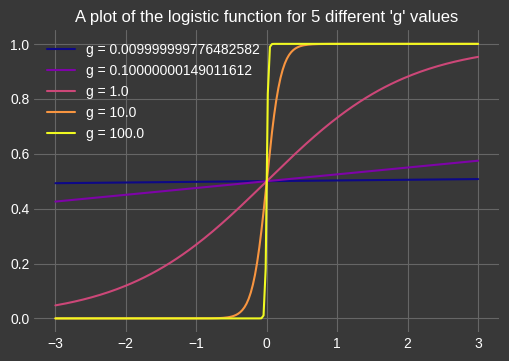

In [ ]:
coordinates = torch.linspace(-3,3, 200)
n_curves = 5
cmap = matplotlib.cm.get_cmap('plasma')

# plotting the logistic function for 5 different g values
for i, g in enumerate(torch.logspace(-2,2,n_curves)):
  color = cmap(i/(n_curves-1))
  values = logistic_func(coordinates, g)
  plt.plot(coordinates,values, color=color, label=f"g = {g}")

plt.title(f"A plot of the logistic function for {n_curves} different 'g' values")
plt.legend();


### 2.1 ❓ Define the penalized objective function 🌋
----
Produce a contour plot of the **penalized** objective function over $[-5,5]×[-5,5]$ with the unfeasible region hatched-out. Use a slider widget (see [this notebook](https://colab.research.google.com/drive/1vAfrR4CiACw0n899xC8uJ3UMwKyonCQa?usp=sharing) for examples of widget use) to make the corresponding plot interactive to changes in the values of $r$, $g$, and $\rho$.

Write a function that takes in `sample_grid`, `radius`, `growth_rate`, `rho` and a function `f` that spits out the z_values given a sample from the grid. Name this function `penalized_objective_function`.

In [ ]:
def penalized_objective_func(sample_grid, radius, growth_rate, rho, f):
  x = sample_grid[0]
  y = sample_grid[1]
  func =  f(sample_grid) + rho * logistic_func((x**2 + y**2 - radius**2), growth_rate)
  return func

### 2.2 ❓ Visualize the penalized objective function

In [ ]:
@widgets.interact(
    radius = widgets.FloatSlider(value=2, min=0, max=5, continuous_update=False),
    growth_rateg = widgets.FloatSlider(value=100, min=0, max=100, continuous_update=False),
    rho = widgets.FloatSlider(value=1, min=0, max=1000, continuous_update=False)
    )
def plot_penalized_func(radius, growth_rateg, rho):

  ## TO DO ## Get the penalized values


  penalized_values = penalized_objective_func(grid, radius, growth_rateg, rho, styblinski_tang)

  

  plt.figure(figsize=(5,4))
  ## TO DO ## Plot the contours of the penalized values and the constraints
  plt.contourf(grid_x.numpy(), grid_y.numpy(), penalized_values.numpy(), levels=50, cmap="plasma")
  # plot_constraints(radius, bounds, resolution, constraint_func)

  ## TO DO ## Set the x and y limits using the bounds you defined in 1.1
  plt.ylim(bounds[0],bounds[1])
  plt.xlim(bounds[0],bounds[1])

  # plot attributers
  plt.xlabel("x1")
  plt.ylabel("x2")
  plt.colorbar()

  plt.show()

interactive(children=(FloatSlider(value=2.0, continuous_update=False, description='radius', max=5.0), FloatSli…

### 2.3 ❓ Optimize (minimize) the penalized objective function and visualize the optimization history 📉
---
This last step will have less guidance, but you can refer to the class notebook. Like in the [autodiff notebook coded in class](https://colab.research.google.com/drive/1vAfrR4CiACw0n899xC8uJ3UMwKyonCQa?usp=sharing), use `PyTorch`'s built-in autodiff engine and `Adam` optimizer to minimize the penalized function we wrote and produce:
1. a contour plot of the penalized function with the non-feasible region hatched-out and the optimization path
2. a plot of the evolution of the objective function as it is minimized

Like for the other questions in this notebook, we wrapped the function you will write with a decorator that makes your output interactive and allows you to test different values of $r$ ($>=0$), $g$ ($>0$), and $\rho$ ($>0$), as well as different starting points for the optimization.


In [ ]:
@widgets.interact(
    radius = widgets.FloatSlider(value=2, min=0, max=5, continuous_update=False),
    growth_rate = widgets.FloatSlider(value=5, min=0, max=20, continuous_update=False),
    rho = widgets.FloatSlider(value=50, min=0, max=100, continuous_update=False),
    x1= widgets.FloatSlider(value=0, min=-5, max=5, continuous_update=False),
    x2=widgets.FloatSlider(value=0, min=-5, max=5, continuous_update=False)
    )
def optimize(radius, growth_rate, rho, x1, x2):
  ## TO DO ##
  x = torch.tensor([x1,x2], requires_grad=True)

  n_iterations = 1000
  history = {"coordinates":[], "value":[]}
  optimizer = torch.optim.Adam([x],lr=0.01)

  for i in range(n_iterations):
    optimizer.zero_grad()
    objective = penalized_objective_func(x, radius, growth_rate, rho, styblinski_tang)

    history["value"].append(objective.item())
    history["coordinates"].append(x.clone().detach().numpy())

    objective.backward()
    optimizer.step()

  penalized_values = penalized_objective_func(grid, radius, growth_rate, rho, styblinski_tang)

  # plot attributes
  plt.figure(figsize=(5,4))
  plt.contourf(grid_x.numpy(), grid_y.numpy(), penalized_values.numpy(), levels=50, cmap="plasma")
  plot_constraints(radius, bounds, resolution, constraint_func)
  plt.colorbar()

  optimization_path = np.array(history["coordinates"])
  plt.plot(optimization_path[:,0],optimization_path[:,1], color="white")


  plt.xlabel("x1")
  plt.ylabel("x2")
  

  plt.figure(figsize=(5,4),dpi=100)
  plt.plot(history["value"])

  plt.show()

interactive(children=(FloatSlider(value=2.0, continuous_update=False, description='radius', max=5.0), FloatSli…

### 2.4 ❓ Use your work above to experiment with different values of $g$ and $\rho$ (fix $r=2$).
----

Are there values of these parameters for which the solution found is non-feasible (beyond a tolerance of $0.001$)? Record the corresponding plots and comment concisely on the influence of these parameters on the solutions found.


# B. Constrained optimization with 3 variables

In Question A, we optimized the z_value of the Styblinski Tang function over **2 variables**, x and y. We used `pytorch` which didn't have any constrained optimization algorithms, and thus we had to design our objective function to be differentiable.

In Question B, we will revist the n-pod problem using `nlopt` library for optimization, which comes with unconstrained and constrained algorithms right of the box. And unlike question A and the notebook from the lecture, we will revist the n-pod problem but now we will be optimizing over **3 variables**: `height`, `r_offset` and `radius`.


That means we are now operating in a 3D design space, which we will visualize using 3D plots. To do so, we will generate a 3D grid of points, where we will evaluate the objective function and the constraints. We will then build a small interactive app that will allows us to visualize everything at once: objective, constraint, optimization path, etc.

## 0.0 | Setup and imports 🚧

### 0.1 | First, we need to clone the repository that has all the helper functions we need for the n-pod problem.

In [4]:
!git clone https://github.com/danhaive/4.453x-resources.git
!mkdir "/content/utils"
!mv  "/content/4.453x-resources/02/analysis.py" "/content/utils/analysis.py"
!rm -r "/content/4.453x-resources"

Cloning into '4.453x-resources'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 160 (delta 47), reused 136 (delta 32), pack-reused 0
Receiving objects: 100% (160/160), 39.85 MiB | 11.23 MiB/s, done.
Resolving deltas: 100% (47/47), done.


### 0.2 | Then, we will import the helper functions from the repository we just installed.

In [5]:
# custom analysis and geometry generation code
from utils.analysis import solve, compute_axial_forces, compute_element_lengths

## Question 1.0 | Define the Design Space

We will be creating the same n-pod design geometry in this notebook. The parameters of the n-pod again are:
1. **Radius** - *the radius of the circle where the bars are supported.*
2. **Number of bars**, _n_
3. **Height** - *the height of the center of the n-pod from the origin*
4. **Offset** - *the offset of the center of the n-pod from the origin*
5. **Force angle** - *the angle of the force on the applied to the center point of the n-pod (in degrees)*


In the previous notebook, we already visualized the geometry as a function of its parameters, so we'll skip it here and focus solely on the optimization.

### 1.1 | Functions to generate and analyze the n-pod structure

In [6]:
@lru_cache(32)
def generate_npod_geometry(base_radius, n_bars, height, r_offset):
    """
    Creates the n-pod structure from the geometry-related input variables.
    Returns the structure as represented by arrays of vertices (points) and edges (bars), which are defined by the two indices of the vertices they connect to.
    """
    vertices = np.array(
        [
            *[
                [base_radius * np.cos(theta), base_radius * np.sin(theta), 0]
                for theta in np.linspace(0, 2 * np.pi, n_bars + 1)[:-1]
            ],
            [r_offset * base_radius, 0, height],
        ]
    )
    edges = np.array([[i, n_bars] for i in range(n_bars)])
    return vertices, edges


@lru_cache(32)
def generate_and_analyze_npod(base_radius, n_bars, height, r_offset, force_angle=30):
    """
    Returns the axial forces by calculating the displacement, using the imported "solve" and "compute_axial_forces" functions to perform the actual structural analysis.
    """
    vertices, edges = generate_npod_geometry(base_radius, n_bars, height, r_offset)
    loads = np.zeros_like(vertices)
    loads[-1] = np.array(
        [-np.cos(force_angle * np.pi / 180), 0, -np.sin(force_angle * np.pi / 180)]
    )
    supports = {i: [1, 1, 1] for i in range(n_bars)}
    displacements = solve(
        vertices, edges, loads, supports, areas=np.array([1] * edges.shape[0])
    )
    axial_forces = compute_axial_forces(vertices, edges, displacements)
    return vertices, edges, axial_forces

### 1.2 | Performance computation

In [7]:
def compute_performance(
    vertices,
    edges,
    forces,
):
    return np.sum(np.abs(forces) * compute_element_lengths(vertices, edges))


@lru_cache(32)
def evaluate_npod(base_radius, n_bars, height, r_offset, force_angle):
    """
    Returns the "performance" of a given n-pod instance, which is proportional to the required structural material volume as explained above
    (a lower value is better).
    """
    vertices, edges, forces = generate_and_analyze_npod(
        base_radius, n_bars, height, r_offset, force_angle
    )

    performance = compute_performance(vertices, edges, forces)

    return performance

## Question 2.0 | Define the optimization problem

### 2.1 | Constants
The base radius is now a design variable, and we do not need to fix its values anymore. But the force angle and number of bars will be fixed.

In [8]:
force_angle = 75
n_bars = 5

### 2.2 | Optimization functions and constraints
These are unchanged except that they take in one additional argument (the extra design variable).

In [9]:
# Optimization functions and constraints

def objective_func(
    height,
    r_offset,
    base_radius,
    callback=None,
):
    """
    Returns the performance score (or objective function value) of the design defined by the variables
    The performance metric is defined inside the evaluate_npod() function
    """
    score = evaluate_npod(
        base_radius,
        n_bars,
        height,
        r_offset,
        force_angle=force_angle,
    )
    # this callback will allow us to call some custom function at every iteration of the optimization
    # for example, we could use it to record the history of the optimization path
    if callback:
        callback([base_radius, height, r_offset])
    return score

  
def save_history_callback(params, history):
    history += [params]


@lru_cache(32)
def min_length_constraint_func(height, r_offset, radius, min_bar_length):
    """
    Returns the shortest bar length minus the minimum allowed bar length.
    If the returned value is greater than zero, then the constraint is met.
    """
    vertices, edges = generate_npod_geometry(radius, n_bars, height, r_offset)
    return min_bar_length- np.min(compute_element_lengths(vertices, edges))


@lru_cache(32)
def max_length_constraint_func(height, r_offset, radius, max_bar_length):
    """
    Returns the longest bar length minus the maximum allowed bar length.
    If the returned value is greater than zero, then the constraint is met.
    """
    vertices, edges = generate_npod_geometry(radius, n_bars, height, r_offset)
    return  np.max(compute_element_lengths(vertices, edges)) - max_bar_length


# Setting the max and min limits of the variables we want to optimize
bounds_height = [1, 10]
bounds_r_offset = [0, 1]
bounds_radius = [1, 6]
bounds = np.array([bounds_height, bounds_r_offset, bounds_radius])

### 2.3 ❓ Normalization

The design variables have different ranges/bounds (which were set in the cell above). For example, the height of the structure can vary between 1 and 10 and the radius offset can vary between 0 and 1. For clarity, we would like to visualize the optimization landscape in the unit cube. 

To help, we define the functions below that allow us to normalize and un-normalize (i.e. project our variables to the unit, or 0 to 1, interval and back).

*Note: normalization can also help numerically. It is not uncommon to normalize variables for optimization purpose as they can rescale the problem in ways that improve convergence. In deep learning for example, datasets of images are often normalized such that their pixel values are scaled to [0,1]  or standardized such that they have a mean of 0 and a standard deviation of 1.*

Implement two functions `normalize` and `unnormalize` which project points from the design space to the unit cube and back. Your functions should take two arguments: `x`, an array of points to normalize (with `shape=[number of points, 3]`), and bounds, an array of bounds (with `shape=[3,2]`).

To make sure your functions work as intended use the `numpy` tests already included in the subsequent cell.

In [10]:
def normalize(x: np.ndarray, bounds: np.ndarray):
  ## TO DO ##
  min_bounds = bounds[:, 0]
  max_bounds = bounds[:, 1]
  return (x - min_bounds) / (max_bounds - min_bounds)

def unnormalize(x: np.ndarray, bounds: np.ndarray):
  ## TO DO ##
  min_bounds = bounds[:, 0]
  max_bounds = bounds[:, 1]
  return x * (max_bounds - min_bounds) + min_bounds

In [11]:
test_array = np.concatenate([bounds, ((bounds[:, 1] + bounds[:, 0])/2)[...,None]], axis=1).T
normalized_test_array = np.array(
    [
     [ 0.,  0. ,  0. ],
     [ 1. ,  1. ,  1. ],
     [ .5,  .5,  .5]
     ]
     )

normalized_array = normalize(test_array, bounds)
unnormalize_array = unnormalize(normalized_array, bounds)


np.testing.assert_allclose(normalized_test_array, normalized_array)
np.testing.assert_allclose(unnormalize_array, test_array)

## Question 3.0 | Visualizing the objective function and the constraints
Let's visualize the relevant functions. We'll visualize the objective function both as a grid of points and as a volume.

As for the constraints, we will visualize them using so-called isosurfaces (i.e. surfaces on which the constraint is equal to a given value). Why? Because the boundary imposed by a constraint on a 3D design space is a surface. If it's an equality constraint, then the solution must be found on the surface, and if it's an inequality constraint, it cannot be past the surface.

In higher dimensions, it is still useful to think of constraints as surfaces bounding your feasible region.

### 3.1 | Helper function for evaluating scalar functions over many points
The objective and constraints cannot be evaluated on a list of points/samples at once (they were simply not coded in a way that accomodates it). To avoid having to write list comprehensions or for loops every single time, we create a helper function that abstracts it away.

In [12]:
def evaluate_scalar_func(pts, func):
    return np.array([func(sample[0], sample[1], sample[2]) for sample in pts])

### 3.2 ❓ Generate a grid of points in 3d 
To visualize our functions, we will need a grid of points (in 3D). Generate a grid of points with the specified `resolution`. Assign your grid to a variable `pts`. The list of points should have the shape `[n_points,3]`.

What are we doing here? 🎉 Grid sampling 🎉

In [13]:
resolution = 20

 ## Add your code here ##
def generate_grid(resolution):
  x = np.linspace(bounds_height[0], bounds_height[1], resolution)
  y = np.linspace(bounds_r_offset[0], bounds_r_offset[1], resolution)
  z = np.linspace(bounds_radius[0], bounds_radius[1], resolution)
  xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
  pts = np.column_stack([xx.ravel(), yy.ravel(), zz.ravel()])
  return (pts,(xx,yy,zz))
pts_xyz = generate_grid(resolution)
pts = pts_xyz[0]
X = pts_xyz[1][0]
Y = pts_xyz[1][1]
Z = pts_xyz[1][2]
 ## TO DO ## 
print(pts.shape)

(8000, 3)


In [33]:
print(type(pts[:, 0]))
print(pts.shape)
# print(pts[:, 1].shape)
# print(pts[:, 2].shape)

<class 'numpy.ndarray'>
(8000, 3)


### 3.3 ❓ Computing the objective values

Compute the objective values at the grid points using `evaluate_scalar_func` and `objective_func`. Assign the results to a variable `objective_values`.

In [15]:
objective_values = evaluate_scalar_func(pts, objective_func)
print("The objective landscape lies between {0:0.2f} and  {1:0.2f}".format(np.min(objective_values),  np.max(objective_values)))

The objective landscape lies between 2.05 and  320.45


In [34]:
print(type(objective_values))
print(objective_values.shape)

<class 'numpy.ndarray'>
(8000,)


In [17]:
normalized_pts = normalize(pts, bounds)
print(normalized_pts)

[[0.         0.         0.        ]
 [0.         0.         0.05263158]
 [0.         0.         0.10526316]
 ...
 [1.         1.         0.89473684]
 [1.         1.         0.94736842]
 [1.         1.         1.        ]]


### 3.4 ❓ Visualize objective function
With these objective values, we can generate two kinds of visualizations using plotly. First, we can visualize the objective function landscape with a simple 3d scatter plot, where each point is colored based on the objective function. Second, we can visualize the landscape with a volume plot, the 3d equivalent of a 2d heatmap.

plotly uses a simple technique to visualize volumes: it visualizes many iso-surfaces with a user-defined opacity. A better technique for volume visualization is volume ray marching but it's not available with plotly. In any case, despite the simplicity of the rendering technique used here, the volume plot is much more revealing in this case, but that's not always necessarily true.

❗❗❗ The cell below uses colab's built-in parser to expose two sliders that you can use to change the values of min_objective and max_objective. Use those two values to filter and visualize only those samples in the design space with objective values in between these two bounds (respectively lower and upper). Produce two visualizations: a 3D scatter plot (hint: use go.Scatter3d) showing only those filtered points and a volume plot (hint: use go.Volume) showing only the regions of the space within the bounds. Both of your plots should use color to indicate the magnitude of the objective function. Note that the cell below already includes styling and layout. You only need to create the two plot objects and assign them to the variables scatter_plot and volume_plot. ❗❗❗


In [63]:
#@title  { run: "auto" }
# @markdown The interactive sliders below can be changed to filter out regions in the landscape that are
# @markdown below or above selected performance thresholds.
# @markdown The visualization will recompute automatically.

min_objective = 62 #@param {type:"slider", min:2, max:320, step:1}
max_objective = 220 #@param {type:"slider", min:2, max:320, step:1}

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "scene"},{"type": "scene"}]])
objective_mask = (objective_values>=min_objective)*(objective_values<=max_objective)

filtered_pts = pts[objective_mask]
filtered_objective_values = objective_values[objective_mask]

print('Original points:', pts.shape)
print('Objective function values:', objective_values.shape)
print('Filtered points:', filtered_pts.shape)
print('Filtered objective function values:', filtered_objective_values.shape)

x = filtered_pts[:, 0]
y = filtered_pts[:, 1]
z = filtered_pts[:, 2]

print(x.shape)
print(y.shape)
print(z.shape)
scatter_plot = go.Scatter3d(
        x=x, 
        y=y, 
        z=z, 
        mode='markers', 
        marker=dict(color=filtered_objective_values, colorscale='Plasma')
        )


volume_plot = go.Volume(
    x=filtered_pts[:,0],
    y=filtered_pts[:,1],
    z=filtered_pts[:,2],
    value=filtered_objective_values,
    isomin= np.min(filtered_objective_values),
    isomax= np.max(filtered_objective_values),
    opacity=0.3, 
    surface_count=5,
    coloraxis="coloraxis",
    )
                    

fig.add_trace(scatter_plot, row=1, col=1)
fig.add_trace(volume_plot, row=1, col=2)

fig.update_layout(coloraxis=dict(colorscale='Plasma'), showlegend=False)

fig.update_scenes(xaxis_title_text='Height',  
                  yaxis_title_text='Offset',  
                  zaxis_title_text='Radius',
                  xaxis_showbackground=False,
                  yaxis_showbackground=False,
                  zaxis_showbackground=False,
                  xaxis = dict(range=bounds[0]),
                  yaxis = dict(range=bounds[1]),
                  zaxis = dict(range=bounds[2])
                  )

fig.update_layout(margin=dict(r=5, l=5, b=5, t=5),height=700,)

Original points: (8000, 3)
Objective function values: (8000,)
Filtered points: (4276, 3)
Filtered objective function values: (4276,)
(4276,)
(4276,)
(4276,)


### 3.5 ❓ Visualize the constraints

Like before, this design space has two inequality constraints (if they're enabled). Both of these constraint are written in the standard form $fc_i(x)<=0$. Therefore, the boundaries of these constraints can be plotted as the surfaces defined by $fc_i(x)<=0$. To do so, we can simply compute the values of the constraints for the grid of points like we did for the objective function. Then, we can use `plotly` to directly compute and plot the isosurfaces $fc_i(x)<=0$.

❗❗❗ Complete the `create_desing_space_figure` function. The code already includes the calculations of the constraints at the grid points. Use those values and the previously computed `objective_values` to generate a 3D plot that overlays a volume plot of the objective function and isosurface plots (hint: use `go.Isosurface`) of the constraints (which display the boundaries of the two constraints). ❗❗❗ 

In [ ]:
#@title  { run: "auto" }
#@title  { form-width: "600px" }
min_bar_length = 3 #@param {type:"slider", min:0, max:5, step:1}
max_bar_length = 5 #@param {type:"slider", min:0, max:10, step:1}
def create_design_space_figure(min_bar_length, max_bar_length):
    
  p1 = evaluate_scalar_func(
      pts,
      lambda x1, x2, x3: min_length_constraint_func(x1, x2, x3, min_bar_length=min_bar_length),
  )
  p2 = evaluate_scalar_func(
      pts,
      lambda x1, x2, x3: max_length_constraint_func(x1, x2, x3, max_bar_length=max_bar_length),
  )
  fig = go.Figure([
                    go.Volume(
    x=pts[:,0],
    y=pts[:,1],
    z=pts[:,2],
    value=objective_values,
    isomin= np.min(objective_values),
    isomax= np.max(objective_values),
    opacity=0.3, 
    surface_count=30,
    coloraxis="coloraxis"
    ),
    go.Isosurface(
    x=pts[:,0],
    y=pts[:,1],
    z=pts[:,2],
    value=p1,
    isomin=0,
    isomax=0,
    opacity=1,
    surface_count=1, # number of isosurfaces, 2 by default: only min and max
    colorbar=None,
    colorscale='earth',
    showscale=False
    ),
    go.Isosurface(
    x=pts[:,0],
    y=pts[:,1],
    z=pts[:,2],
    value=p2,
    opacity=1,
    isomin=0,
    isomax=0,
    surface_count=1, # number of isosurfaces, 2 by default: only min and max
    caps=dict(x_show=False, y_show=False),
    colorscale='earth',
    showscale=False
    )])
  fig.update_layout(coloraxis=dict(colorscale='Plasma'), showlegend=False)
  fig.update_scenes(xaxis_title_text='Height',  
                    yaxis_title_text='Offset',  
                    zaxis_title_text='Radius',
                    xaxis_showbackground=False,
                    yaxis_showbackground=False,
                    zaxis_showbackground=False,
                    xaxis = dict(range=bounds[0]),
                    yaxis = dict(range=bounds[1]),
                    zaxis = dict(range=bounds[2])
                    )
  fig.update_layout(margin=dict(r=5, l=5, b=5, t=5),height=600,)
  return fig
create_design_space_figure(min_bar_length,max_bar_length).show()

## Question 4.0 Optimization
We've defined most of what we need: the objective function, the constraints, the optimization algorithms. We have also visualized the problem. We can run the optimization using NLOpt using a few lines of code. In the end, we will  bring everything together and build an interactive app with `plotly` and `ipywidgets` (you don't have to code the app, but it is good to go through it and learn how it works).

### 4.1 ❓ Helper function
The ability to read and understand code you have not written yourself is super important because you'll often find yourself using and/or reimplementing existing code to build on previous research.

❗❗❗
No need to code anything in the cell below, just explain! By inspecting the cell below and the code that uses it, explain the purpose and implementation of `function_with_approx_grad`. Feel free to refer to the n-pod notebook covered in class and/or the `nlopt` documentation.
❗❗❗ 

In [ ]:
def function_with_approx_grad(f, eps):
    def f_with_grad(x, grad):
        if grad.size > 0:
            grad[:] = scipy.optimize.approx_fprime(x, f, eps)
        return f(x)

    return f_with_grad

### 4.2 | Constraint Algorithms
Let's use a selection of algorithms available in `nlopt`.

In [ ]:
constrained_algorithms = {
    "COBYLA [constrained, local, derivative-free]": nlopt.LN_COBYLA,
    "SLSQP [constrained, local, gradient- and hessian-based]": nlopt.LD_SLSQP,
    "ISRES [constrained, global, derivative-free]": nlopt.GN_ISRES,
}

unconstrained_algoritms = {
    "LBFGS [unconstrained, gradient- and hessian-based]": nlopt.LD_LBFGS,
    "ESCH [unconstrained, evolutionary and derivative-free]": nlopt.GN_ESCH,
}

all_algorithms = {**constrained_algorithms, **unconstrained_algoritms}

### 4.3 ❓ Define a callback to keep track of the optimization path.

❗❗❗ No need to code anything in the cell below, just explain! Where and how is this function used? ❗❗❗ 

In [ ]:
def save_history_callback(params, history):
    history += [params]

### 4.4 | Optimzation constants/hyperparameters

In [ ]:
MAX_N_ITER = 1000
F_TOL = 0.01
GRAD_CALC_EPS = 0.01

### 4.5 ❓ Define a function to plot the optimization path

In [ ]:
def plot_optimization_path(fig, opt_history, bounds, xopt):
  
  scatter_plot_start =  go.Scatter3d(
        x=[(bounds[0][0] + bounds[0][1]) / 2],
        y=[(bounds[1][0] + bounds[1][1]) / 2],
        z=[(bounds[2][0] + bounds[2][1]) / 2],
        mode='markers',
        marker=dict(
            size=10,
            color="blue"
        )
    )

  scatter_plot_end = go.Scatter3d(
        x=[xopt[0]],
        y=[xopt[1]],
        z=[xopt[2]],
        mode='markers',
        marker=dict(
            size=10,
            color="green"
        )
    )
  
  line_plot = go.Scatter3d(
        x=opt_history[:, 1],
        y=opt_history[:, 2],
        z=opt_history[:, 0],
        mode='lines',
        line=dict(
            color="white",
            width=2
        ))

  scatter_plot = go.Scatter3d(
    x=opt_history[:, 1],
    y=opt_history[:, 2],
    z=opt_history[:, 0],
    mode='markers',
    marker=dict(
        size=2,
        color="white"
    ))

  
  # adding plots to figure
  fig.add_trace(line_plot)
  fig.add_trace(scatter_plot)
  fig.add_trace(scatter_plot_start)
  fig.add_trace(scatter_plot_end)


  return fig

### 4.6 | Adding items to widgets for the interactive app

In [ ]:
# Here, we are just adding the algorithms to the interactive widget so that we have them as options to choose from
algorithm_selection = widgets.Dropdown(
    options=constrained_algorithms, # change to all_algorithms?
    layout={"width": "max-content"},
    description="Algorithm",
)

In [ ]:
# Defining the 'slider'  widgets' visuals and what description they will have next to them
# These widgets are called the "widgets.Checkbox" and "widgets.IntSlider"
min_length_slider = widgets.IntSlider(
    min=0, max=10, value=4, continuous_update=False, indent=False, description="Minimum Bar Length Constraint"
)
max_length_slider = widgets.IntSlider(min=5, max=15, value=10, description ="Maximum Bar Length Constraint",continuous_update=False)

### 4.7 | Write a function to visualize the plot with constraints and optimization path

In [ ]:
output = widgets.Output()
def visualize_problem(opt_history=None, xopt=None):
    """
    A function that plots our optimization problem
    It utilizes the previous plot definitions to show
    the constraints as hatches if they are checked
    and the optimization path once the optimization is run
    """
    min_bar_length, max_bar_length = min_length_slider.value, max_length_slider.value
    with output:
        clear_output(wait=True)
        figure = create_design_space_figure(min_bar_length, max_bar_length)
        # plots the optimization path only if it has been run and stored in opt_history
        if opt_history is not None:
            figure = plot_optimization_path(figure, opt_history, bounds, xopt)
            figure.show()
        display(figure)
# Just to keep track of any change in the widgets sliders and checkbox
min_length_slider.observe(visualize_problem, names=["value"])
max_length_slider.observe(visualize_problem, names=["value"])

### 4.8 ❓ Write a function that runs the optimization for different algorithms
Remember, we are using the `nlopt` library here, which has documentation that is different from `pytorch`

In [ ]:
def run_optimization(self):
    """
    Runs the Optimization for different algorithms
    and considering different constraint options
    It also runs the visualize_problem() to update the plot
    """
    run_opt_button.disabled = True

    # This sets the start point for the optimization at the center of the design space
    x0 = np.mean(bounds, axis=1)  

    # Defining the optimizer with 3 for 3 variables using nlopt
    opt = nlopt.opt(algorithm_selection.value, 3) 

    ## TO DO ## Set optimizer's properties for max iterations and tolerance
    opt.set_maxeval(MAX_N_ITER)
    opt.set_ftol_rel(F_TOL)
    ### TO DO ## Set the lower and upper bounds of the optimizer
    opt.set_lower_bounds(bounds[:, 0])
    opt.set_upper_bounds(bounds[:, 1])

    # defining optimzer history to store data in
    opt_history = []

    ## TO DO ## Set the minimum objective of the optimizer
    opt.set_min_objective(
        function_with_approx_grad(
            lambda x: objective_func(
                *x, callback=lambda y: save_history_callback(y, opt_history)
            ),
            GRAD_CALC_EPS,
        )
    )


    #  we will add the min constraint to the optimizer 
    opt.add_inequality_constraint(
        function_with_approx_grad(
            lambda x: min_length_constraint_func(*x, min_length_slider.value),
            GRAD_CALC_EPS,
        ),
        0,
      )
    
    # we will add the max constraint to the optimizer 
    opt.add_inequality_constraint(
        function_with_approx_grad(
            lambda x: max_length_constraint_func(*x, max_length_slider.value),
            GRAD_CALC_EPS,
        ),
        0,
    )

    try:
        xopt = opt.optimize(x0)
        opt_history = np.array(opt_history)
        visualize_problem(opt_history=opt_history, xopt=xopt)
    except Exception as e:
        opt_history = np.array(opt_history)
        visualize_problem(opt_history=opt_history, xopt=None)
        with output:
            print(f"Optimization failed to converge. Reason: {str(e)}")
    run_opt_button.disabled = False


### 4.9 | Defining a few buttons and controls for the interactive app

In [ ]:
# Defining the button to click for running the optimizatoin
run_opt_button = widgets.Button(
    description="Optimize",
    disabled=False,
    button_style="",
    tooltip="Run optimization",
)


run_opt_button.on_click(run_optimization)

# Defining the controls which we can interact with to be displayed
controls = widgets.VBox(
    [
        widgets.HBox([min_length_slider]),
        widgets.HBox([max_length_slider]),
        algorithm_selection,
        run_opt_button,
        output,
    ]
)

### 4.10 | Running the interactive app

In [ ]:
# Visualizing the plot and displaying the widget controls
display(controls)
visualize_problem()

# SUBMISSION LINKS

### ❗❗❗ Submit a link to the document where you recorded the requested observations below. Make sure it is viewable by the teaching staff. 


Your link 💻 >https://docs.google.com/document/d/1HpCmpthUBmBNHVz_Y8fGRyDakptDMV1T7W1ineQ2IU4/edit?usp=sharing

### ❗❗❗ Submit a link to your completed [quiz](https://colab.research.google.com/drive/1k3ckHifi-otfNlBQQSqPmWPSJMvYveYx?usp=sharing) notebook below. Make sure it is viewable by the teaching staff.

Your link 💻 >https://colab.research.google.com/drive/1C4-YWFvfVjfYnAlXSqJkRz7OWN_WPXjS?usp=sharing


# Another one in the books!! 🤓👏

💡 To recap, in this homework you learned how to:

- Visualize a constrained problem.
- Optimize a constrained problem over 2 variables using `Pytorch`.
- Design the objective function to make it differentiable.
- Optimize a constrained problem over 3 variables using  `nlopt`.
- Create an interactive app to visualization the optimization path.
